In [1]:
# for imports
import sys
sys.path.append('../')

import io, os, cv2, requests, time, json
import pandas as pd
import numpy as np
from PIL import Image
from utils.camera import Camera
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: 
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## select model type

In [2]:
use_model = 'MobileNetV2'
# use_model = 'InceptionV3'
if use_model == 'InceptionV3':
    model = keras.applications.inception_v3.InceptionV3()
    preprocess_function = tf.keras.applications.inception_v3.preprocess_input
elif use_model == 'MobileNetV2':
    model = keras.applications.MobileNetV2()
    preprocess_function = tf.keras.applications.mobilenet_v2.preprocess_input 
else:
    print('use_mode must be set')

## load pretrained model and labels

In [3]:
# load imagenet labels 

# try local file
try:
    print('try to load labels from local file...')
    with open('../images/imagenet_labels.json') as json_file:
        json_data = json.load(json_file)
    
except:
    print('try to load labels from internet...')
    LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
    response = requests.get(LABELS_URL)  
    json_data = response.json()
    

labels = {int(key): value for key, value in json_data.items()}

print(len(labels), 'labels found')

try to load labels from local file...
1000 labels found


## functions for preprocessing (resize, scale rgb values) and prediction

In [4]:
# preprocess
def preprocess_image(img):
    start_time= time.time()
    img = img.resize(tuple(model.input.shape)[1:3])
    img_array = np. array(img)
    img_array = img_array.reshape(1, model.input.shape[1], model.input.shape[2], model.input.shape[3])
    img_array = preprocess_function(img_array)
    duration = time.time() - start_time
    return img_array, duration    

In [5]:
# predict
def predict_from_image_array(img_array):
    start_time= time.time()
    pred_proba = model.predict(img_array)
    duration = time.time() - start_time
    return pd.DataFrame({
        'label' : [labels[i] for i in labels.keys()],
        'proba' : list(pred_proba[0])}), duration

## predict image from file

In [6]:
img = Image.open("../images/dog.jpg")
img_array, _ = preprocess_image(img)
df, _ = predict_from_image_array(img_array)
print(df.nlargest(1, 'proba')[['label','proba']].values[0][0], df.nlargest(1, 'proba')[['label','proba']].values[0][1])

flat-coated retriever 0.7771855592727661


## predict images from internet and check time
if image is to big -> the preprocessiong time is longer than prediction

In [7]:
urls = ['https://upload.wikimedia.org/wikipedia/commons/b/bb/Kittyply_edit1.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/5/5c/Fox---Vulpes-corsac---%28Gentry%29.jpg',
       'https://upload.wikimedia.org/wikipedia/commons/0/04/VW_Golf_2_Red_ca_1990_dept_54.JPG',
       'https://upload.wikimedia.org/wikipedia/commons/0/0c/Fussball.jpg']

tiger cat 	 time prepr./pred.:0.24s/0.36s image size (1728, 1152)
kit fox 	 time prepr./pred.:0.60s/0.37s image size (3000, 2250)
beach wagon 	 time prepr./pred.:0.03s/0.37s image size (557, 322)
soccer ball 	 time prepr./pred.:0.01s/0.37s image size (253, 266)


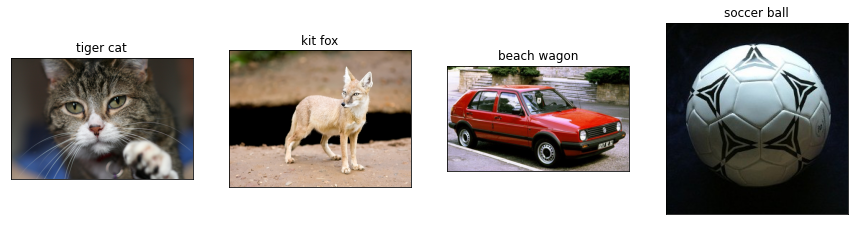

In [93]:
fig = plt.figure(figsize=(15, 10))
for i, url in enumerate(urls):
    # load image
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))
    
    # predict label
    img_array, duration_preprocess = preprocess_image(img)
    df, duration_predict = predict_from_image_array(img_array)
    pred_label = df.nlargest(1, 'proba')[['label','proba']].values[0][0].split(',')[0]
    pred_proba = df.nlargest(1, 'proba')[['label','proba']].values[0][1]

    # draw image
    ax = fig.add_subplot(1, len(urls), i + 1)
    plt.imshow(img)
    ax.set_title(pred_label)
    ax.set_xticks([])
    ax.set_yticks([])
    print(f'{pred_label} \t time prepr./pred.:{duration_preprocess:0.2f}s/{duration_predict:0.2f}s image size {img.size}')

## predict from camera

In [62]:
# initialize only one time
if 'camera0' not in locals():
    camera0 = Camera(capture_device=0, width=model.input.shape[1], height=model.input.shape[2], 
                     capture_width=1280, capture_height=720, capture_fps=30, flip_mode=-1, debug=True)

In [63]:
img_rgb = camera0.get_image_rgb()
img = Image.fromarray(img_rgb, 'RGB')
img_array, duration_preprocess = preprocess_image(img)
df, duration_predict = predict_from_image_array(img_array)
pred_label = df.nlargest(1, 'proba')[['label','proba']].values[0][0].split(',')[0]
pred_proba = df.nlargest(1, 'proba')[['label','proba']].values[0][1]
print(f'{pred_label} - time preprocess / prediction:{duration_preprocess:0.2f}s / {duration_predict:0.2f}s')

vacuum - time preprocess / prediction:0.00s / 0.35s


## live prediction with camera

In [97]:
duration = 10 # running time in seconds

from IPython.display import display
import ipywidgets.widgets as widgets
image_widget = widgets.Image(format='jpeg', width=300, height=300)
label_widget = widgets.Text(description='detected')
confidence_widget = widgets.Text(description='confidence')
time_widget = widgets.Text(description='pred. time')
progress_widget = widgets.FloatProgress(value=0, min=0.0, max=float(duration), description='running time')

display(widgets.HBox([image_widget, 
                      widgets.VBox([label_widget, confidence_widget, time_widget, progress_widget])]))

start_time = time.time()
while time.time() - start_time < duration:
    img_rgb = camera0.get_image_rgb()
    img = Image.fromarray(img_rgb, 'RGB')
    img_array, duration_preprocess = preprocess_image(img)
    df, duration_predict = predict_from_image_array(img_array)
    pred_label = df.nlargest(1, 'proba')[['label','proba']].values[0][0].split(',')[0]
    pred_proba = df.nlargest(1, 'proba')[['label','proba']].values[0][1]
    label_widget.value = pred_label
    confidence_widget.value = f'{pred_proba *100:0.0f} %'
    time_widget.value = f'{duration_predict:0.2f} sec'
    image_widget.value = bytes(cv2.imencode('.jpg', img_rgb)[1])
    progress_widget.value = (time.time() - start_time)



## try with TensorRT

In [11]:
# crashes the kernel. even with more swap

#from tensorflow.python.compiler.tensorrt import trt_convert as trt
#model = keras.applications.inception_v3.InceptionV3()
#model.save('../models/inceptionv3_orig')
#converter = trt.TrtGraphConverterV2(input_saved_model_dir='../models/inceptionv3_orig')
#converter.convert()
#converter.save('../models/inceptionv3_tensorrt')
